# Regularization

Deep Learning models have so much flexibility and capacity that **overfitting can be a serious problem**, if the training dataset is not big enough. Sure it does well on the training set, but the learned network **doesn't generalize to new examples** that it has never seen!

We will use regularization in our deep learning models in this notebook and see following:
- Regularization will help us reduce overfitting.
- Regularization will drive our weights to lower values.
- L2 regularization and Dropout are two very effective regularization techniques.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import sklearn
import sklearn.datasets
import sklearn.linear_model
import scipy.io

def sigmoid(x):
    """
    Compute the sigmoid of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(x)
    """
    s = 1/(1+np.exp(-x))
    return s

def relu(x):
    """
    Compute the relu of x

    Arguments:
    x -- A scalar or numpy array of any size.

    Return:
    s -- relu(x)
    """
    s = np.maximum(0,x)
    
    return s

def load_planar_dataset(seed):
    
    np.random.seed(seed)
    
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y

def initialize_parameters(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing our parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    b1 -- bias vector of shape (layer_dims[l], 1)
                    Wl -- weight matrix of shape (layer_dims[l-1], layer_dims[l])
                    bl -- bias vector of shape (1, layer_dims[l])
                    
    Tips:
    - For example: the layer_dims for the "Planar Data classification model" would have been [2,2,1]. 
    This means W1's shape was (2,2), b1 was (1,2), W2 was (2,1) and b2 was (1,1). Now you have to generalize it!
    - In the for loop, use parameters['W' + str(l)] to access Wl, where l is the iterative integer.
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation (and computes the loss) presented in Figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    parameters -- python dictionary containing our parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape ()
                    b1 -- bias vector of shape ()
                    W2 -- weight matrix of shape ()
                    b2 -- bias vector of shape ()
                    W3 -- weight matrix of shape ()
                    b3 -- bias vector of shape ()
    
    Returns:
    loss -- the loss function (vanilla logistic loss)
    """
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def backward_propagation(X, Y, cache):
    """
    Implement the backward propagation presented in figure 2.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat)
    cache -- cache output from forward_propagation()
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing our parameters:
                    parameters['W' + str(i)] = Wi
                    parameters['b' + str(i)] = bi
    grads -- python dictionary containing our gradients for each parameters:
                    grads['dW' + str(i)] = dWi
                    grads['db' + str(i)] = dbi
    learning_rate -- the learning rate, scalar.
    
    Returns:
    parameters -- python dictionary containing our updated parameters 
    """
    
    n = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

def predict(X, y, parameters):
    """
    This function is used to predict the results of a  n-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # Forward propagation
    a3, caches = forward_propagation(X, parameters)
    
    # convert probas to 0/1 predictions
    for i in range(0, a3.shape[1]):
        if a3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    # print results

    #print ("predictions: " + str(p[0,:]))
    #print ("true labels: " + str(y[0,:]))
    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

def compute_cost(a3, Y):
    """
    Implement the cost function
    
    Arguments:
    a3 -- post-activation, output of forward propagation
    Y -- "true" labels vector, same shape as a3
    
    Returns:
    cost - value of the cost function
    """
    m = Y.shape[1]
    
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    
    return cost

def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing our parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
    
def load_2D_dataset():
    data = scipy.io.loadmat('/Users/amanprasad/Documents/Courses_IIT_Fall_2019/DeepLearning/DataSets/Football/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y

In [8]:
import numpy as np

def compute_cost_with_regularization_test_case():
    np.random.seed(1)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 2)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    a3 = np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]])
    return a3, Y_assess, parameters

def backward_propagation_with_regularization_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
         [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]),
  np.array([[ 0.        ,  3.32524635,  2.13994541,  2.60700654,  0.        ],
         [ 0.        ,  4.1600994 ,  0.79051021,  1.46493512,  0.        ]]),
  np.array([[-1.09989127, -0.17242821, -0.87785842],
         [ 0.04221375,  0.58281521, -1.10061918]]),
  np.array([[ 1.14472371],
         [ 0.90159072]]),
  np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [-0.69166075, -3.47645987, -2.25194702, -2.65416996, -0.69166075],
         [-0.39675353, -4.62285846, -2.61101729, -3.22874921, -0.39675353]]),
  np.array([[ 0.53035547,  5.94892323,  2.31780174,  3.16005701,  0.53035547],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]),
  np.array([[ 0.50249434,  0.90085595],
         [-0.68372786, -0.12289023],
         [-0.93576943, -0.26788808]]),
  np.array([[ 0.53035547],
         [-0.69166075],
         [-0.39675353]]),
  np.array([[-0.3771104 , -4.10060224, -1.60539468, -2.18416951, -0.3771104 ]]),
  np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]]),
  np.array([[-0.6871727 , -0.84520564, -0.67124613]]),
  np.array([[-0.0126646]]))
    return X_assess, Y_assess, cache

def forward_propagation_with_dropout_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 2)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    
    return X_assess, parameters

def backward_propagation_with_dropout_test_case():
    np.random.seed(1)
    X_assess = np.random.randn(3, 5)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    cache = (np.array([[-1.52855314,  3.32524635,  2.13994541,  2.60700654, -0.75942115],
           [-1.98043538,  4.1600994 ,  0.79051021,  1.46493512, -0.45506242]]), np.array([[ True, False,  True,  True,  True],
           [ True,  True,  True,  True, False]], dtype=bool), np.array([[ 0.        ,  0.        ,  4.27989081,  5.21401307,  0.        ],
           [ 0.        ,  8.32019881,  1.58102041,  2.92987024,  0.        ]]), np.array([[-1.09989127, -0.17242821, -0.87785842],
           [ 0.04221375,  0.58281521, -1.10061918]]), np.array([[ 1.14472371],
           [ 0.90159072]]), np.array([[ 0.53035547,  8.02565606,  4.10524802,  5.78975856,  0.53035547],
           [-0.69166075, -1.71413186, -3.81223329, -4.61667916, -0.69166075],
           [-0.39675353, -2.62563561, -4.82528105, -6.0607449 , -0.39675353]]), np.array([[ True, False,  True, False,  True],
           [False,  True, False,  True,  True],
           [False, False,  True, False, False]], dtype=bool), np.array([[ 1.06071093,  0.        ,  8.21049603,  0.        ,  1.06071093],
           [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
           [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]]), np.array([[ 0.50249434,  0.90085595],
           [-0.68372786, -0.12289023],
           [-0.93576943, -0.26788808]]), np.array([[ 0.53035547],
           [-0.69166075],
           [-0.39675353]]), np.array([[-0.7415562 , -0.0126646 , -5.65469333, -0.0126646 , -0.7415562 ]]), np.array([[ 0.32266394,  0.49683389,  0.00348883,  0.49683389,  0.32266394]]), np.array([[-0.6871727 , -0.84520564, -0.67124613]]), np.array([[-0.0126646]]))


    return X_assess, Y_assess, cache
    

In [9]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import scipy.io

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

**Problem Statement**: We have just been hired as an AI expert by the French Football Corporation. They would like us to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

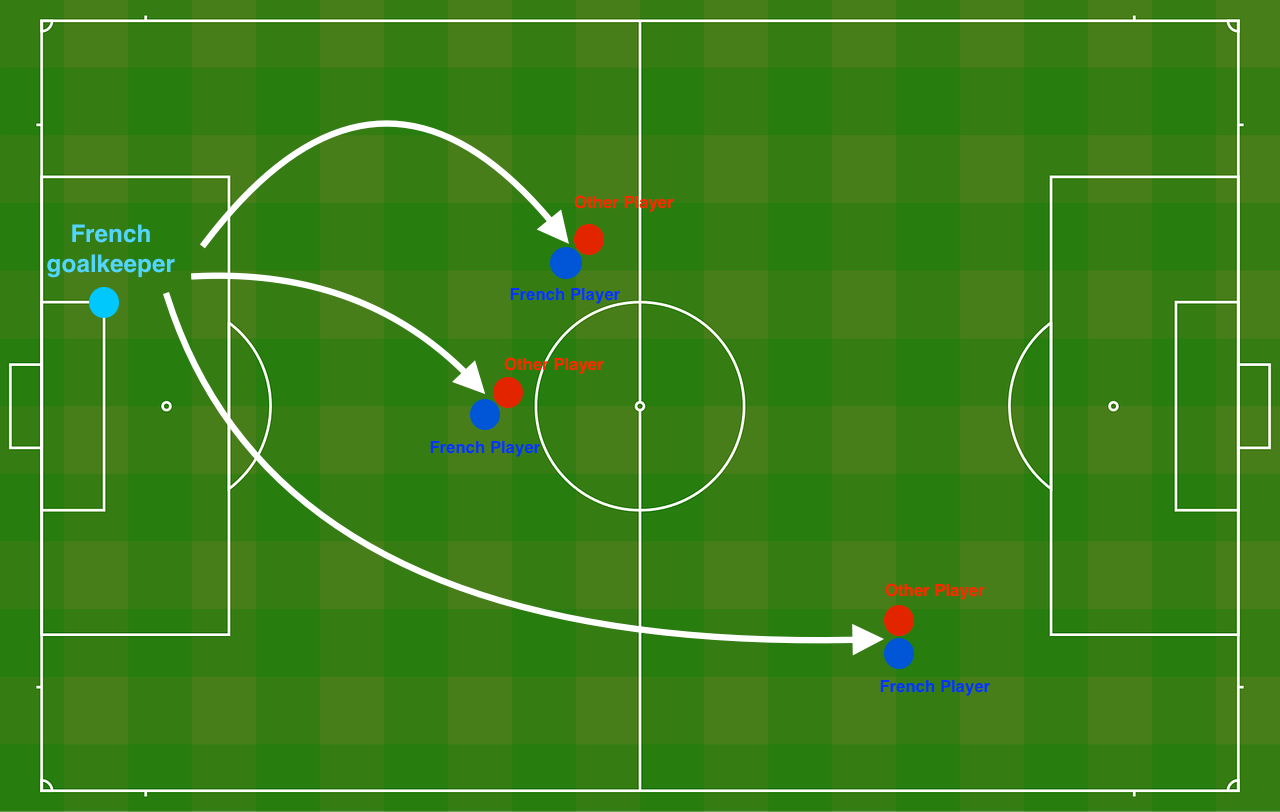

In [10]:
from IPython.display import Image
Image(filename='/Users/amanprasad/Desktop/field_kiank.png')

Football field 

The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head.

They give you the following 2D dataset from France's past 10 games.

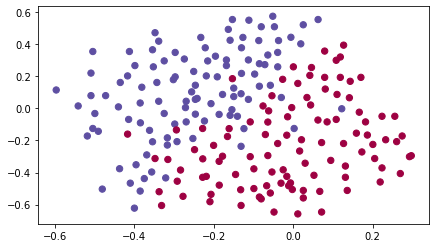

In [11]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Our goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well. 

We will first try a non-regularized model. Then we'll learn how to regularize it and decide which model we will choose to solve the French Football Corporation's problem. 

## Non-regularized model

We will use the following neural network. This model can be used:
- in *regularization mode* -- by setting the `lambd` input to a non-zero value.
- in *dropout mode* -- by setting the `keep_prob` to a value less than one

We will first try the model without any regularization. Then, we will implement:
- *L2 regularization* -- functions: "`compute_cost_with_regularization()`" and "`backward_propagation_with_regularization()`"
- *Dropout* -- functions: "`forward_propagation_with_dropout()`" and "`backward_propagation_with_dropout()`"

In each part, we will run this model with the correct inputs so that it calls the functions we've implemented.

In [12]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert(lambd==0 or keep_prob==1)    # it is possible to use both L2 regularization and dropout, 
                                            # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Let's train the model without any regularization, and observe the accuracy on the train/test sets.

Cost after iteration 0: 0.6557412523481002
Cost after iteration 10000: 0.16329987525724213
Cost after iteration 20000: 0.1385164242325169


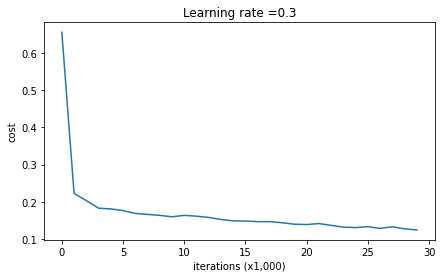

On the training set:
Accuracy: 0.9478672985781991
On the test set:
Accuracy: 0.915


In [13]:
parameters = model(train_X, train_Y)
print ("On the training set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The train accuracy is 94.8% while the test accuracy is 91.5%. This is the **baseline model** (we will observe the impact of regularization on this model).

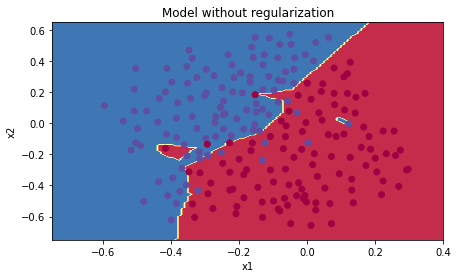

In [14]:
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

The non-regularized model is obviously overfitting the training set. It is fitting the noisy points! Lets now look at two techniques to reduce overfitting.

## L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. It consists of appropriately modifying our cost function, from:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$
To:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Let's modify our cost and observe the consequences.

We implement `compute_cost_with_regularization()` which computes the cost given by formula (2). To calculate $\sum\limits_k\sum\limits_j W_{k,j}^{[l]2}$

In [15]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives us the cross-entropy part of the cost
    
    L2_regularization_cost = (1/m)*(lambd/2)*np.sum([np.sum(np.square(W1)),np.sum(np.square(W2)),np.sum(np.square(W3))])
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [16]:
A3, Y_assess, parameters = compute_cost_with_regularization_test_case()

print("cost = " + str(compute_cost_with_regularization(A3, Y_assess, parameters, lambd = 0.1)))

cost = 1.7864859451590758


Of course, because we changed the cost, we have to change backward propagation as well! All the gradients have to be computed with respect to this new cost. 

We implement the changes needed in backward propagation to take into account regularization. The changes only concern dW1, dW2 and dW3. For each, we have to add the regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

In [17]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + (lambd/m)*W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + (lambd/m)*W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + (lambd/m)*W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [18]:
X_assess, Y_assess, cache = backward_propagation_with_regularization_test_case()

grads = backward_propagation_with_regularization(X_assess, Y_assess, cache, lambd = 0.7)
print ("dW1 = \n"+ str(grads["dW1"]))
print ("dW2 = \n"+ str(grads["dW2"]))
print ("dW3 = \n"+ str(grads["dW3"]))

dW1 = 
[[-0.25604646  0.12298827 -0.28297129]
 [-0.17706303  0.34536094 -0.4410571 ]]
dW2 = 
[[ 0.79276486  0.85133918]
 [-0.0957219  -0.01720463]
 [-0.13100772 -0.03750433]]
dW3 = 
[[-1.77691347 -0.11832879 -0.09397446]]


Let's now run the model with L2 regularization $(\lambda = 0.7)$. The `model()` function will call: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.2684918873282239
Cost after iteration 20000: 0.2680916337127301


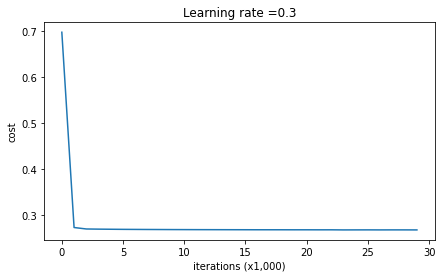

On the train set:
Accuracy: 0.9383886255924171
On the test set:
Accuracy: 0.93


In [19]:
parameters = model(train_X, train_Y, lambd = 0.7)
print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

The test set accuracy increased to 93%. We have saved the French football team!

We are not overfitting the training data anymore. Let's plot the decision boundary.

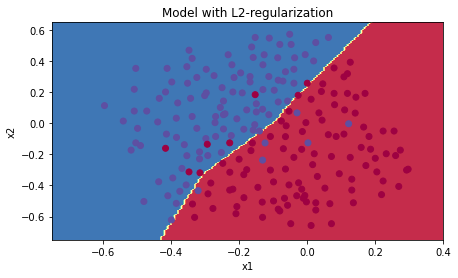

In [21]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Observations**:
- The value of $\lambda$ is a hyperparameter that we can tune using a dev set.
- L2 regularization makes our decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What is L2-regularization actually doing?**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function we drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

## Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning. 
**It randomly shuts down some neurons in each iteration.**

When we shut some neurons down, we actually modify our model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of our neurons. With dropout, our neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 

### Forward propagation with dropout

We implement the forward propagation with dropout. We are using a 3 layer neural network, and will add dropout to the first and second hidden layers. We will not apply dropout to the input layer or output layer. 

**Instructions**:
You would like to shut down some neurons in the first and second layers. To do that, you are going to carry out 4 Steps:
1. We will create a variable $d^{[1]}$ with the same shape as $a^{[1]}$ using `np.random.rand()` to randomly get numbers between 0 and 1. Here, we will use a vectorized implementation, so create a random matrix $D^{[1]} = [d^{[1](1)} d^{[1](2)} ... d^{[1](m)}] $ of the same dimension as $A^{[1]}$.
2. Set each entry of $D^{[1]}$ to be 1 with probability (`keep_prob`), and 0 otherwise.

**Note:** If we say that keep_prob = 0.8, which means that we want to keep about 80% of the neurons and drop out about 20% of them.  We want to generate a vector that has 1's and 0's, where about 80% of them are 1 and about 20% are 0.

3. Set $A^{[1]}$ to $A^{[1]} * D^{[1]}$. (We are shutting down some neurons). We can think of $D^{[1]}$ as a mask, so that when it is multiplied with another matrix, it shuts down some of the values.
4. Divide $A^{[1]}$ by `keep_prob`. By doing this we are assuring that the result of the cost will still have the same expected value as without drop-out. (This technique is also called inverted dropout.)

In [22]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing our parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
                                                      # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(A1.shape[0],A1.shape[1])      # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob).astype(int)                 # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1 * D1                                      # Step 3: shut down some neurons of A1
    A1 = A1/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down

    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    D2 = np.random.rand(A2.shape[0],A2.shape[1])      # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob).astype(int)                 # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    A2 = A2 * D2                                      # Step 3: shut down some neurons of A2
    A2 = A2/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [23]:
X_assess, parameters = forward_propagation_with_dropout_test_case()

A3, cache = forward_propagation_with_dropout(X_assess, parameters, keep_prob = 0.7)
print ("A3 = " + str(A3))

A3 = [[0.36974721 0.00305176 0.04565099 0.49683389 0.36974721]]


### Backward propagation with dropout

We implement the backward propagation with dropout. As before, we are training a 3 layer network. Add dropout to the first and second hidden layers, using the masks $D^{[1]}$ and $D^{[2]}$ stored in the cache. 

We will have to carry out 2 Steps:
1. We had previously shut down some neurons during forward propagation, by applying a mask $D^{[1]}$ to `A1`. In backpropagation, we will have to shut down the same neurons, by reapplying the same mask $D^{[1]}$ to `dA1`. 
2. During forward propagation, we had divided `A1` by `keep_prob`. In backpropagation, we'll therefore have to divide `dA1` by `keep_prob` again (the calculus interpretation is that if $A^{[1]}$ is scaled by `keep_prob`, then its derivative $dA^{[1]}$ is also scaled by the same `keep_prob`).

In [24]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)
    dA2 = dA2 * D2                   # Step 1: Apply mask D2 to shut down the same neurons as during the forward propagation
    dA2 = dA2/keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 = dA1 * D1                   # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1/keep_prob              # Step 2: Scale the value of neurons that haven't been shut down
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [25]:
X_assess, Y_assess, cache = backward_propagation_with_dropout_test_case()

gradients = backward_propagation_with_dropout(X_assess, Y_assess, cache, keep_prob = 0.8)

print ("dA1 = \n" + str(gradients["dA1"]))
print ("dA2 = \n" + str(gradients["dA2"]))

dA1 = 
[[ 0.36544439  0.         -0.00188233  0.         -0.17408748]
 [ 0.65515713  0.         -0.00337459  0.         -0.        ]]
dA2 = 
[[ 0.58180856  0.         -0.00299679  0.         -0.27715731]
 [ 0.          0.53159854 -0.          0.53159854 -0.34089673]
 [ 0.          0.         -0.00292733  0.         -0.        ]]


Let's now run the model with dropout (`keep_prob = 0.86`). It means at every iteration we shut down each neurons of layer 1 and 2 with 14% probability. The function `model()` will now call:
- `forward_propagation_with_dropout` instead of `forward_propagation`.
- `backward_propagation_with_dropout` instead of `backward_propagation`.

Cost after iteration 0: 0.6543912405149825


/Users/amanprasad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:236: RuntimeWarning: divide by zero encountered in log
/Users/amanprasad/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:236: RuntimeWarning: invalid value encountered in multiply


Cost after iteration 10000: 0.061016986574905605
Cost after iteration 20000: 0.060582435798513114


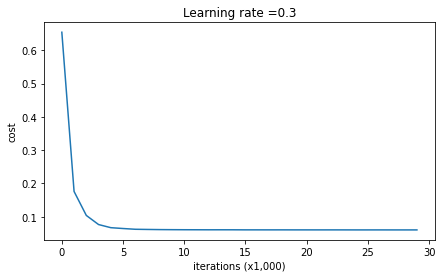

On the train set:
Accuracy: 0.9289099526066351
On the test set:
Accuracy: 0.95


In [26]:
parameters = model(train_X, train_Y, keep_prob = 0.86, learning_rate = 0.3)

print ("On the train set:")
predictions_train = predict(train_X, train_Y, parameters)
print ("On the test set:")
predictions_test = predict(test_X, test_Y, parameters)

Dropout works great! The test accuracy has increased again (to 95%)! Our model is not overfitting the training set and does a great job on the test set. The French football team will be forever grateful!

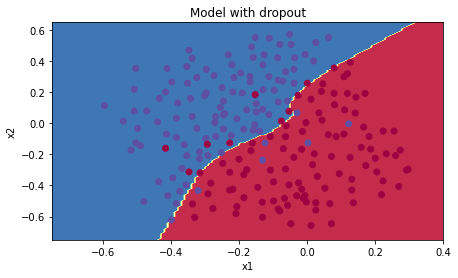

In [27]:
plt.title("Model with dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

**Things to remember about dropout:**    
- Dropout is a regularization technique.
- We only use dropout during training. Don't use dropout (randomly eliminate nodes) during test time.
- Apply dropout both during forward and backward propagation.
- During training time, divide each dropout layer by keep_prob to keep the same expected value for the activations. For example, if keep_prob is 0.5, then we will on average shut down half the nodes, so the output will be scaled by 0.5 since only the remaining half are contributing to the solution. Dividing by 0.5 is equivalent to multiplying by 2. Hence, the output now has the same expected value. We can check that this works even when keep_prob is other values than 0.5.  

## Conclusions

**Here are the results of our three models**: 

| Model                                         | Train accuracy  | Test accuracy  | 
| ----------------------------------------      | --------------- | ---------------|
| 3-layer NN without regularization             | 95%             | 91.5%          | 
| 3-layer NN with L2-regularization             | 94%             | 93%            | 
| 3-layer NN with dropout                       | 93%             | 95%            | 



Note that regularization hurts training set performance! This is because it limits the ability of the network to overfit to the training set. But since it ultimately gives better test accuracy, it is helping our system. 